# **Pange Rank**

# Library

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re, sys, time
from urllib.parse import urljoin, urlparse
import urllib3
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
import builtwith

# Analisis teknologi yang digunakan
res = builtwith.parse('https://sivitas.sakera.id')
print(res)

{'cdn': ['CloudFlare']}


# Crawl Link

In [7]:
import pandas as pd
import requests, time
from bs4 import BeautifulSoup
from urllib.parse import urljoin

def crawl_recursive(start_url, max_depth=2, delay=1):
    """
    Crawl secara rekursif:
    start_url: URL awal
    max_depth: kedalaman maksimum (1 = hanya halaman awal, 2 = halaman awal + link di dalamnya, dst)
    delay: jeda antar request

    Return DataFrame dengan kolom: id, page, link
    """
    session = requests.Session()
    session.headers.update({"User-Agent": "Mozilla/5.0"})

    visited = set()  # URL yang sudah dikunjungi
    results = []
    link_id = 1

    # Queue untuk BFS: (url, depth, parent_url)
    queue = [(start_url, 0, None)]

    while queue:
        current_url, depth, parent = queue.pop(0)
        if current_url in visited:
            continue
        visited.add(current_url)

        # Ambil halaman
        try:
            r = session.get(current_url, timeout=15)
            r.raise_for_status()
        except Exception as e:
            print(f"Gagal akses {current_url}: {e}")
            continue

        soup = BeautifulSoup(r.content, "html.parser")
        all_links = soup.find_all("a", href=True)

        # Simpan setiap link ditemukan
        for a in all_links:
            href = a["href"]
            absolute_link = urljoin(current_url, href)  # jadi URL penuh

            results.append({
                "id": link_id,
                "page": current_url,  # halaman asal
                "link": absolute_link  # link ditemukan di halaman ini
            })
            link_id += 1

            # Jika belum mencapai max_depth, tambahkan ke queue untuk di-crawl lagi
            if depth + 1 < max_depth:
                queue.append((absolute_link, depth + 1, current_url))

        time.sleep(delay)  # jeda agar tidak overload server

    df = pd.DataFrame(results)
    return df

# Contoh penggunaan:
df_crawl = crawl_recursive("https://pta.trunojoyo.ac.id/", max_depth=2)
print(df_crawl.head())

# Simpan ke CSV
df_crawl.to_csv("recursive_crawl.csv", index=False, encoding="utf-8-sig")
print("Hasil tersimpan ke recursive_crawl.csv")

Gagal akses https://pta.trunojoyo.ac.id/: HTTPSConnectionPool(host='pta.trunojoyo.ac.id', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7b5232effc80>: Failed to resolve 'pta.trunojoyo.ac.id' ([Errno -2] Name or service not known)"))
Empty DataFrame
Columns: []
Index: []
Hasil tersimpan ke recursive_crawl.csv


# Baca data hasil crawl

In [9]:
df = pd.read_csv("recursive_crawl.csv")
df.head()

,id,page,link
0,1,https://pta.trunojoyo.ac.id/,https://pta.trunojoyo.ac.id/index.html
1,2,https://pta.trunojoyo.ac.id/,https://pta.trunojoyo.ac.id/
2,3,https://pta.trunojoyo.ac.id/,https://pta.trunojoyo.ac.id/
3,4,https://pta.trunojoyo.ac.id/,https://pta.trunojoyo.ac.id/c_search/
4,5,https://pta.trunojoyo.ac.id/,https://pta.trunojoyo.ac.id/c_template/


In [14]:
# === 1. Gunakan data 'link' yang sudah dibaca ===
# Pastikan kolom: 'page' (asal), 'link' (tujuan)
edges = df[['page', 'link']].copy()

# Tentukan node unik
nodes = pd.Index(sorted(set(edges['page']).union(edges['link'])))
n = len(nodes)
print(f"Jumlah node: {n}")

# Buat mapping node → index
node_to_index = {node: i for i, node in enumerate(nodes)}

Jumlah node: 481


# Bangun matriks adjacency

In [16]:
# === 2. Bangun matriks adjacency ===
A = np.zeros((n, n), dtype=float)
for _, row in edges.iterrows():
    i = node_to_index[row['page']]
    j = node_to_index[row['link']]
    A[j, i] = 1  # arah page → link

# Normalisasi kolom (stochastic matrix)

In [17]:
# === 3. Normalisasi kolom (stochastic matrix) ===
col_sums = A.sum(axis=0)
for j in range(n):
    if col_sums[j] == 0:
        A[:, j] = 1.0 / n    # dangling node → teleportasi penuh
    else:
        A[:, j] /= col_sums[j]

# Inisialisasi dan iterasi PageRank

In [18]:
# === 4. Inisialisasi dan iterasi PageRank ===
r = np.ones(n) / n
d = 0.85
epsilon = 1e-6
iteration = 0

while True:
    r_new = d * A @ r + (1 - d) / n
    diff = np.linalg.norm(r_new - r, 1)
    iteration += 1
    print(f"Iterasi {iteration}: diff = {diff:.8f}")
    if diff < epsilon:
        break
    r = r_new

Iterasi 1: diff = 0.16395951
Iterasi 2: diff = 0.10105287
Iterasi 3: diff = 0.06196653
Iterasi 4: diff = 0.03799178
Iterasi 5: diff = 0.02329266
Iterasi 6: diff = 0.01428067
Iterasi 7: diff = 0.00875544
Iterasi 8: diff = 0.00536793
Iterasi 9: diff = 0.00329107
Iterasi 10: diff = 0.00201774
Iterasi 11: diff = 0.00123707
Iterasi 12: diff = 0.00075845
Iterasi 13: diff = 0.00046500
Iterasi 14: diff = 0.00028509
Iterasi 15: diff = 0.00017479
Iterasi 16: diff = 0.00010716
Iterasi 17: diff = 0.00006570
Iterasi 18: diff = 0.00004028
Iterasi 19: diff = 0.00002470
Iterasi 20: diff = 0.00001514
Iterasi 21: diff = 0.00000928
Iterasi 22: diff = 0.00000569
Iterasi 23: diff = 0.00000349
Iterasi 24: diff = 0.00000214
Iterasi 25: diff = 0.00000131
Iterasi 26: diff = 0.00000080


# Hasil PageRank

In [19]:
# === 5. Hasil PageRank ===
Pagerank_df = pd.DataFrame({
    'Page': nodes,
    'PageRank': r
}).sort_values(by='PageRank', ascending=False)

print("Top 5 page dengan PageRank tertinggi:")
Pagerank_df.head(5)

Top 5 page dengan PageRank tertinggi:


,Page,PageRank
33,https://library.trunojoyo.ac.id/detil.php?id=23,0.005836
11,http://trunojoyo.ac.id,0.005836
99,https://pta.trunojoyo.ac.id/c_search/byfac/99,0.005759
238,https://pta.trunojoyo.ac.id/c_template/,0.005759
169,https://pta.trunojoyo.ac.id/c_search/byprod/25,0.005759


# Visualisasi Hasil PageRank

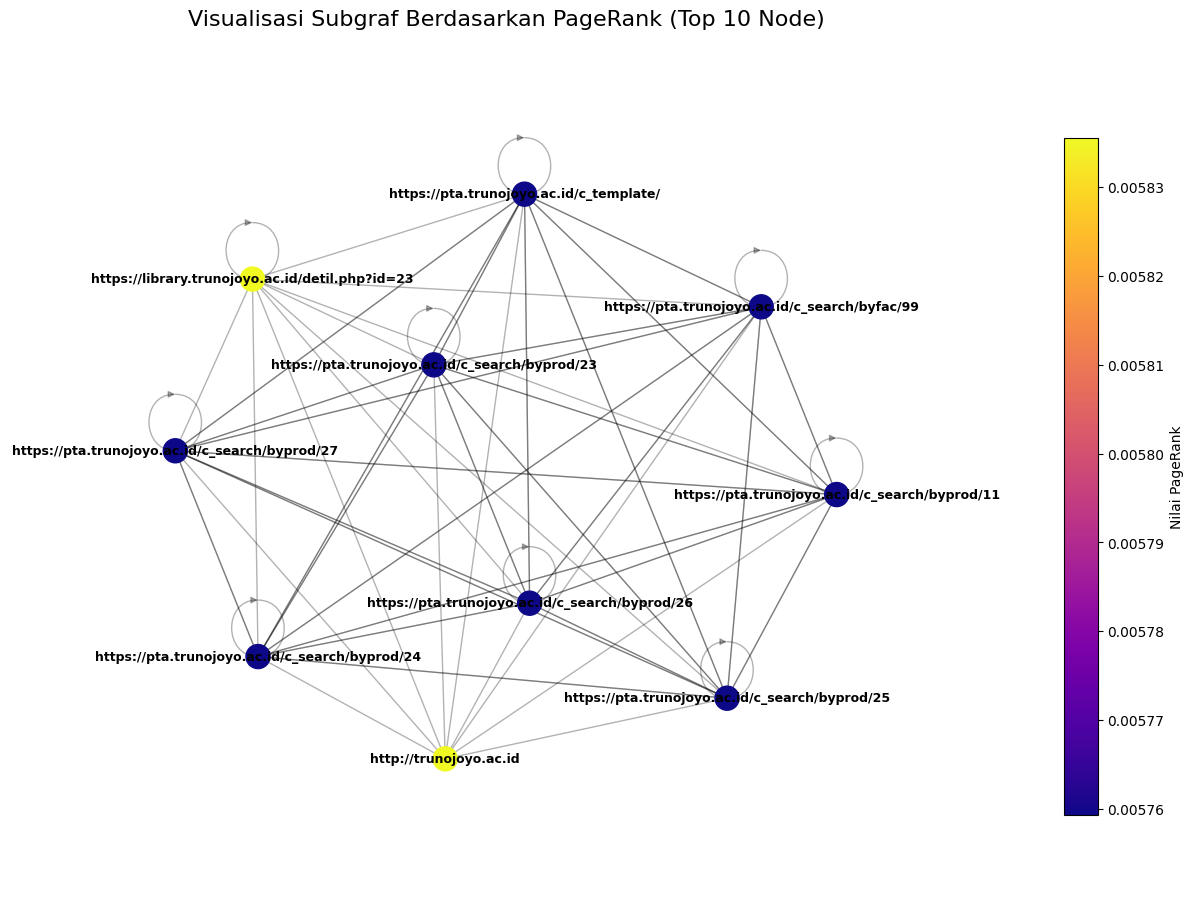

In [20]:
# === 6. Buat Graph untuk Visualisasi ===
edges_viz = edges.rename(columns={'Page': 'From', 'Link Keluar': 'To'})
G = nx.DiGraph()
G.add_edges_from(edges_viz.itertuples(index=False, name=None))

# Ambil 10 node dengan PageRank tertinggi
top_nodes = Pagerank_df.head(10)['Page'].tolist()
H = G.subgraph(top_nodes).copy()

# Warna berdasarkan nilai PageRank
pr_sub = dict(zip(Pagerank_df['Page'], Pagerank_df['PageRank']))
node_colors = [pr_sub.get(n, 0) for n in H.nodes()]

# === 7. Visualisasi Graf ===
fig, ax = plt.subplots(figsize=(16, 11))
pos = nx.kamada_kawai_layout(H)

# Gambar node dan edge
nx.draw_networkx_nodes(
    H, pos,
    node_color=node_colors,
    cmap=plt.cm.plasma,
    node_size=300,
    ax=ax
)
nx.draw_networkx_edges(H, pos, alpha=0.3, arrows=False, ax=ax)

# Tambahkan label node
nx.draw_networkx_labels(
    H, pos,
    font_size=9,
    font_color='black',
    font_weight='bold',
    verticalalignment='center',
    horizontalalignment='center',
    ax=ax
)

# Hitung batas posisi node untuk perluasan area gambar
x_values = [p[0] for p in pos.values()]
y_values = [p[1] for p in pos.values()]
x_margin = (max(x_values) - min(x_values)) * 0.25
y_margin = (max(y_values) - min(y_values)) * 0.25

ax.set_xlim(min(x_values) - x_margin, max(x_values) + x_margin)
ax.set_ylim(min(y_values) - y_margin, max(y_values) + y_margin)

# Tambahkan judul dan colorbar
ax.set_title("Visualisasi Subgraf Berdasarkan PageRank (Top 10 Node)", fontsize=16, pad=20)
ax.axis("off")

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma)
sm.set_array(node_colors)
plt.colorbar(sm, label="Nilai PageRank", ax=ax, shrink=0.8)

plt.show()